# A/B Testing - Pruebas de Hipótesis
## Inferencia Bayesiana aplicada a mensajes de Texto
Tenemos un set de datos con el conteo ddiario de mensajes de texto

In [1]:
import pandas as pd
import pylab as plt
df = pd.read_csv('https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter1_Introduction/data/txtdata.csv')
df.head()

,1.300000000000000000e+01
0,24.0
1,8.0
2,24.0
3,7.0
4,35.0


<BarContainer object of 73 artists>

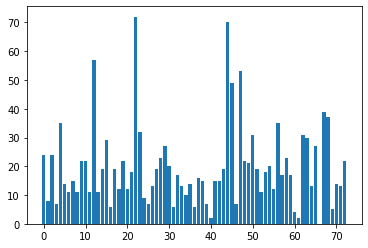

In [9]:
plt.bar(list(df.index), df.iloc[:,0].values)

En algun momento, dentro de los 70 días la empresa cambio sus tarifas

In [10]:
df.iloc[:,0].mean()

19.835616438356166

Al día, la persona manda 20 mensajes en promedio.

In [15]:
change = 40
print(df[df.index < change].mean().values)
print(df[df.index > change].mean().values)

[18.375]
[22.21875]


Hay 3 variables:
1. Día del Cambio
2. Promedio antes del cambio
3. Promedio despúes del cambio

# Número de Mensajes

El número de mensajes es una variable de conteo.
- Ventas por día
- Particulas en una muestra
- Número de autos en un cruce/gasolineras

Utilizamos la distribución de [Poisson](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_de_Poisson)

[Siempre es bueno tener un cheat sheet de distribuciones](https://www.docsity.com/en/probability-cheat-sheet/4176747/)

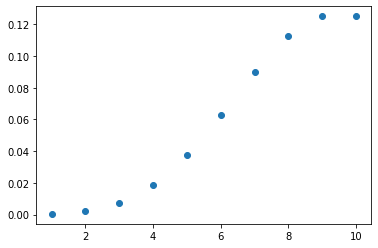

In [19]:
from scipy.stats import poisson
import numpy as np
mu = 10 # Es un parametro que nos dice el numero promedio de eventos
poisson.pmf(2, mu)
x = range(1,11)
fig, ax = plt.subplots(1, 1)
ax.plot(x, poisson.pmf(x, mu), 'o')

Cuantos parametros $\mu$ vamos a tener?

Recordemos que tenemos un paramtero $\mu_1$ anetes del cambio y otro $\mu_2$ despúes del cambio.

# Prior

[Distribución exponencial](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_exponencial)

$\mu \sim \text{Exp}(\alpha)$

# Dia del cambio del comportamiento

Es un día entre 1 y 70, lo cual hace una variable uniforme

In [22]:
print(df.iloc[:, 0].values)

[24.  8. 24.  7. 35. 14. 11. 15. 11. 22. 22. 11. 57. 11. 19. 29.  6. 19.
 12. 22. 12. 18. 72. 32.  9.  7. 13. 19. 23. 27. 20.  6. 17. 13. 10. 14.
  6. 16. 15.  7.  2. 15. 15. 19. 70. 49.  7. 53. 22. 21. 31. 19. 11. 18.
 20. 12. 35. 17. 23. 17.  4.  2. 31. 30. 13. 27.  0. 39. 37.  5. 14. 13.
 22.]


In [0]:
import pymc3 as pm
import theano.tensor as tt

count_data = df.iloc[:, 0]
n_count_data = len(count_data)

# Aqui definimos las Priors
with pm.Model() as model:
  alpha = 1.0 / count_data.mean()
  tau = pm.DiscreteUniform("tau", lower = 0, upper = n_count_data - 1)
  mu_1 = pm.Exponential("mu_1", alpha)
  mu_2 = pm.Exponential("mu_2", alpha)

In [0]:
# Aqui se define el cambio entre Mu_1 y Mu_2
with model:
  idx = np.arange(n_count_data)
  mu_ = pm.math.switch(tau > idx, mu_1, mu_2)

In [0]:
# Aqui se meten los datos
with model:
  observation = pm.Poisson("obs", mu_, observed = count_data) 

$\text{obs} \sim \text{Poisson}(\mathit{mu}=f(f(f(\text{tau}),~array),~f(\text{mu_1}),~f(\text{mu_2})))$

In [30]:
with model:
  step = pm.Metropolis()
  trace = pm.sample(10000, tune = 5000, step = step)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [mu_2]
>Metropolis: [mu_1]
>Metropolis: [tau]
100%|██████████| 15000/15000 [00:08<00:00, 1828.85it/s]
The number of effective samples is smaller than 25% for some parameters.


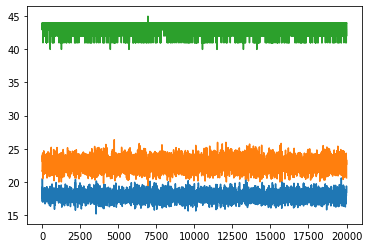

In [36]:
plt.plot(trace['mu_1'])
plt.plot(trace['mu_2'])
plt.plot(trace['tau'])

In [0]:
mu_1_sample = trace['mu_1']
mu_2_sample = trace['mu_2']
tau_sample = trace['tau']

(array([3.000e+01, 0.000e+00, 8.000e+02, 0.000e+00, 2.203e+03, 0.000e+00,
        7.293e+03, 0.000e+00, 9.673e+03, 1.000e+00]),
 array([40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5, 45. ]),
 <a list of 10 Patch objects>)

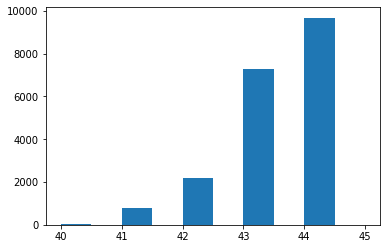

In [38]:
plt.hist(tau_sample)

(array([  32.,  279., 1504., 4152., 5833., 4994., 2451.,  610.,  133.,
          12.]),
 array([19.44373185, 20.13625438, 20.82877692, 21.52129945, 22.21382198,
        22.90634452, 23.59886705, 24.29138959, 24.98391212, 25.67643465,
        26.36895719]),
 <a list of 10 Patch objects>)

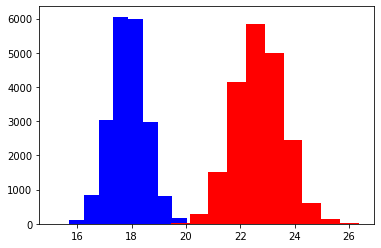

In [41]:
plt.hist(mu_1_sample, color = 'blue')
plt.hist(mu_2_sample, color = 'red')